In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

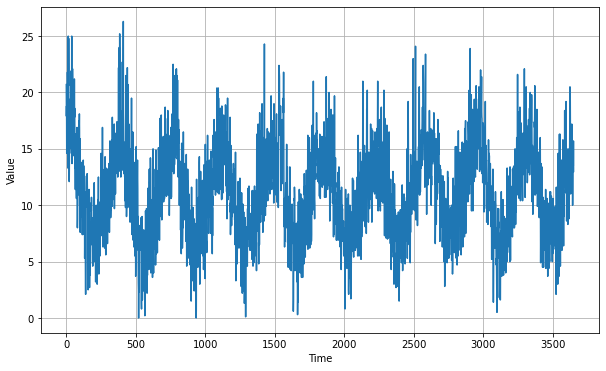

In [4]:
import csv
time_step = []
temps = []

#El archivo .csv está en el mismo directorio.
#Este archivo contiene la temperatura minima diaria de la ciudad de londres desde 1980 hasta 1991.
with open('daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')#puntero
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [8]:
split_time = 2500 # marca para la partición

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30 # tamaño de la ventana: últimos 30 dias.
batch_size = 32 # tamaño de bath, 32 datos.
shuffle_buffer_size = 1000 # tamaño del barajeo aleatorio 

In [9]:
#Función que prepara el set de datos dentro del periodo ventada.

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [10]:
#Función que realiza la proyección recibiendo el modelo final y el dataset.

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [11]:
#Entrenamiento de la red neuronal
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 2s 183ms/step - loss: 31.1571 - mae: 31.6550
Epoch 2/100
10/10 [==============================] - 1s 145ms/step - loss: 30.5778 - mae: 31.0756
Epoch 3/100
10/10 [==============================] - 1s 142ms/step - loss: 29.6825 - mae: 30.1801
Epoch 4/100
10/10 [==============================] - 1s 145ms/step - loss: 28.5613 - mae: 29.0586
Epoch 5/100
10/10 [==============================] - 1s 147ms/step - loss: 27.1974 - mae: 27.6945
Epoch 6/100
10/10 [==============================] - 1s 143ms/step - loss: 25.5017 - mae: 25.9986
Epoch 7/100
10/10 [==============================] - 1s 144ms/step - loss: 23.3464 - mae: 23.8429
Epoch 8/100
10/10 [==============================] - 1s 146ms/step - loss: 20.6148 - mae: 21.1108
Epoch 9/100
10/10 [==============================] - 1s 144ms/step - loss: 17.3142 - mae: 17.8091
Epoch 10/100
10/

Epoch 84/100
10/10 [==============================] - 1s 140ms/step - loss: 11.0981 - mae: 11.5968
Epoch 85/100
10/10 [==============================] - 1s 143ms/step - loss: 12.7445 - mae: 13.2432
Epoch 86/100
10/10 [==============================] - 1s 145ms/step - loss: 14.0241 - mae: 14.5223
Epoch 87/100
10/10 [==============================] - 2s 150ms/step - loss: 15.9931 - mae: 16.4914
Epoch 88/100
10/10 [==============================] - 1s 147ms/step - loss: 17.5925 - mae: 18.0906
Epoch 89/100
10/10 [==============================] - 2s 156ms/step - loss: 19.6661 - mae: 20.1594
Epoch 90/100
10/10 [==============================] - 2s 157ms/step - loss: 60.9000 - mae: 61.3973
Epoch 91/100
10/10 [==============================] - 1s 149ms/step - loss: 80.9529 - mae: 81.4529
Epoch 92/100
10/10 [==============================] - 1s 149ms/step - loss: 83.1993 - mae: 83.6993
Epoch 93/100
10/10 [==============================] - 2s 152ms/step - loss: 106.1306 - mae: 106.6306
Epoch 94

(1e-08, 0.0001, 0.0, 60.0)

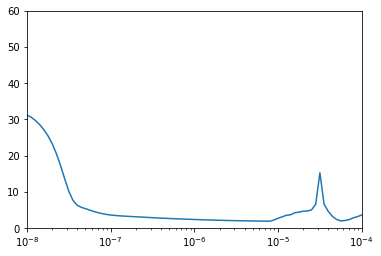

In [12]:
#Selección del hiperparámetro  learning rate del optimizador SGD (descenso del grandiente)
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [13]:
#Modelo final con la elección del learning rate que optimiza la función de pérdida.
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
25/25 [==============================] - 2s 80ms/step - loss: 9.9820 - mae: 10.4701
Epoch 2/150
25/25 [==============================] - 2s 77ms/step - loss: 2.5293 - mae: 2.9921
Epoch 3/150
25/25 [==============================] - 2s 80ms/step - loss: 1.9501 - mae: 2.4046
Epoch 4/150
25/25 [==============================] - 2s 77ms/step - loss: 1.8619 - mae: 2.3151
Epoch 5/150
25/25 [==============================] - 2s 76ms/step - loss: 1.8215 - mae: 2.2733
Epoch 6/150
25/25 [==============================] - 2s 76ms/step - loss: 1.7909 - mae: 2.2418
Epoch 7/150
25/25 [==============================] - 2s 77ms/step - loss: 1.7686 - mae: 2.2186
Epoch 8/150
25/25 [==============================] - 2s 76ms/step - loss: 1.7413 - mae: 2.1906
Epoch 9/150
25/25 [==============================] - 2s 75ms/step - loss: 1.7193 - mae: 2.1681
Epoch 10/150
25/25 [==============================] - 2s 76ms/step - loss: 1.7000 - mae: 2.1483
Epoch 11/150
25/25 [============================

25/25 [==============================] - 2s 75ms/step - loss: 1.5061 - mae: 1.9475
Epoch 87/150
25/25 [==============================] - 2s 75ms/step - loss: 1.5074 - mae: 1.9489
Epoch 88/150
25/25 [==============================] - 2s 75ms/step - loss: 1.5053 - mae: 1.9467
Epoch 89/150
25/25 [==============================] - 2s 75ms/step - loss: 1.5050 - mae: 1.9463
Epoch 90/150
25/25 [==============================] - 2s 75ms/step - loss: 1.5064 - mae: 1.9479
Epoch 91/150
25/25 [==============================] - 2s 75ms/step - loss: 1.5055 - mae: 1.9468
Epoch 92/150
25/25 [==============================] - 2s 76ms/step - loss: 1.5045 - mae: 1.9459
Epoch 93/150
25/25 [==============================] - 2s 75ms/step - loss: 1.5032 - mae: 1.9445
Epoch 94/150
25/25 [==============================] - 2s 76ms/step - loss: 1.5023 - mae: 1.9438
Epoch 95/150
25/25 [==============================] - 2s 77ms/step - loss: 1.5111 - mae: 1.9529
Epoch 96/150
25/25 [==============================] -

In [14]:
#Pronostico
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

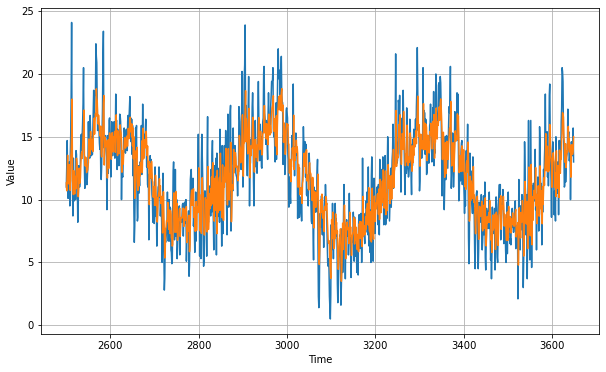

In [17]:
#Set de Validación real Vs pronóstico

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [15]:
#Verificación del error
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.7796186

In [16]:
#Valores de los pronosticos.
rnn_forecast

array([11.327803, 10.704756, 12.123882, ..., 13.604153, 13.796392,
       15.008598], dtype=float32)